<a href="https://colab.research.google.com/github/mk17250/CE888-Lab-8---Transfer-Learning-/blob/main/CE888_lab_8_task_1_Feature_Extraction_transfer_learning_FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os
os.environ['KAGGLE_USERNAME'] = "matthewking210" # username from the json file
os.environ['KAGGLE_KEY'] = "3288a7f24107679e6b927727856bbdc3" # key from the json file
!kaggle competitions download -c dogs-vs-cats # api copied from kaggle (https://www.kaggle.com/c/dogs-vs-cats/data)

sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
# Unzip training data
from zipfile import ZipFile
file_name = "/content/train.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [15]:
# Get all the paths
data_dir_list = os.listdir('/content/train')
#print(data_dir_list)
path, dirs, files = next(os.walk("/content/train"))
file_count = len(files)
print(file_count)

25000


In [16]:
# Make new base directory
original_dataset_dir = '/content/train'
base_dir = '/content/cats_and_dogs_small'
os.mkdir(base_dir)

FileExistsError: ignored

In [17]:
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

FileExistsError: ignored

In [18]:
import shutil
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [19]:
import cv2
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [20]:
def label_img(img):
    word_label = img.split('.')[0]
    if word_label == 'dog': return 1
    elif word_label == 'cat': return 0

In [21]:
def createDataSplitSet(datapath):
    X=[]
    y=[]

    for img in os.listdir(datapath):
        label = label_img(img)
        # print(label)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [22]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)

In [23]:
## VGG 16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [24]:
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax")
model.summary()

553467904/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [25]:
last_layer = model.get_layer('fc2').output
out = Dense(1, activation='sigmoid', name='output')(last_layer)  ## 2 classes
model = Model(img_input, out)

for layer in model.layers[:-1]:
	layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model.h5', save_best_only=True),
]

In [28]:
history = model.fit(train_X, train_y,
                               batch_size=10,
                               epochs=10, 
                               validation_data=(val_X, val_y),
                               callbacks=my_callbacks)

Epoch 1/10
200/200 [==============================] - 72s 194ms/step - loss: 0.5273 - acc: 0.7489 - val_loss: 0.3118 - val_acc: 0.8630
Epoch 2/10
200/200 [==============================] - 39s 193ms/step - loss: 0.3204 - acc: 0.8726 - val_loss: 0.2674 - val_acc: 0.8810
Epoch 3/10
200/200 [==============================] - 39s 193ms/step - loss: 0.2929 - acc: 0.8850 - val_loss: 0.2382 - val_acc: 0.8960
Epoch 4/10
200/200 [==============================] - 39s 193ms/step - loss: 0.2483 - acc: 0.9008 - val_loss: 0.2424 - val_acc: 0.8970
Epoch 5/10
200/200 [==============================] - 39s 193ms/step - loss: 0.2363 - acc: 0.8955 - val_loss: 0.2254 - val_acc: 0.9020
Epoch 6/10
200/200 [==============================] - 39s 193ms/step - loss: 0.2299 - acc: 0.9084 - val_loss: 0.2179 - val_acc: 0.8990
Epoch 7/10
200/200 [==============================] - 39s 193ms/step - loss: 0.1979 - acc: 0.9179 - val_loss: 0.2232 - val_acc: 0.9000
Epoch 9/10
200/200 [==============================] - 3

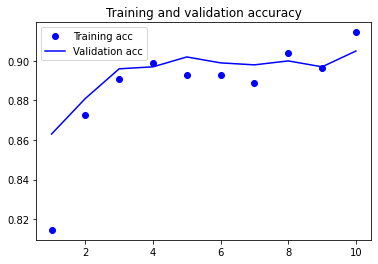

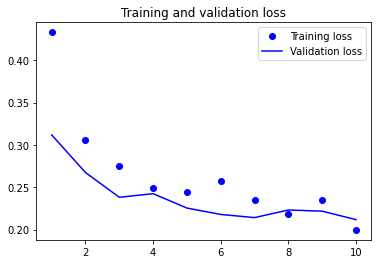

In [29]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='binary')

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 0.9144999980926514
Val Accuracy:	 0.9049999713897705
Test Accuracy:	 0.907
Precision:	 0.9320594479830149
Recall:		 0.878
F1 Score:	 0.9042224510813595
AUC:		 0.907
